In [140]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
cal_imgs = ['camera_cal/calibration%d.jpg'%(x) for x in range(1,21)]
straight_imgs = ['test_images/straight_lines%d.jpg'%(x) for x in [1,2]]
test_imgs = ['test_images/test%d.jpg'%(x) for x in range(1,7)]
all_imgs = straight_imgs+test_imgs
nx,ny=9,6
image_shape = (1280, 720) #gray.shape[::-1]
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def get_chessboard_corners(fname):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        return corners
    else:
        return None    
    
def calibrate_camera(fnames):
    imgpoints = []
    objpoints_chessboard = np.stack(np.meshgrid(range(9),range(6),range(1)), axis=-1).reshape(-1,3).astype(np.float32)
    objpoints = []
    for fname in fnames:
        new_imgpoints = get_chessboard_corners(fname)
        if new_imgpoints is not None:
            imgpoints.append(new_imgpoints)
            objpoints.append(objpoints_chessboard)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    return ret,mtx,dist,rvecs,tvecs

def get_perspective_trf():
    src = np.asarray([[295,660],[1023,660],[766,500],[518,500]],dtype=np.float32)
    dst = np.asarray([[295,660],[1023,660],[1023,500],[295,500]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M,Minv

def undistort(img,mtx,dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
        

def genvideo(input_video_file,output_video_file,frame_trf):
    test_clip = VideoFileClip(input_video_file)
    new_clip = test_clip.fl_image(frame_trf) #NOTE: this function expects color images!!
    new_clip.write_videofile(output_video_file, audio=False)
    
def showvideo(vfile):    
    vtemplate="""<video width="640" height="300" controls><source src="{0}" type="video/mp4"></video>"""
    return HTML(vtemplate.format(vfile))

def threshold_img(val,thrs):
    ret = np.zeros_like(val)
    ret[(val>thrs[0]) & (val<=thrs[1])]=1
    return ret

def calc_lane_base(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base,rightx_base


def binary_image(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    s_binary = threshold_img(hls[:,:,2],(90, 255))
    sxbinary = threshold_img(scaled_sobelx,(20,100))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def get_potential_lane_pixels_by_windowing(combined_binary,out_img):
    leftx_base,rightx_base = calc_lane_base(combined_binary)
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    nwindows = 9
    window_height = np.int(combined_binary.shape[0]/nwindows)
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []  
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    return leftx,lefty,rightx,righty

def radius_of_curvature(xpts,ypts):
    fit_cr = np.polyfit(ypts*ym_per_pix,xpts*xm_per_pix,2)
    y_eval=720
    return ((1+(2*fit_cr[0]*y_eval*ym_per_pix+fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])

def find_lanes(undist_img,M,Minv):
    rgb = cv2.warpPerspective(undist_img, M, image_shape, flags=cv2.INTER_LINEAR)
    combined_binary = binary_image(rgb)
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    leftx,lefty,rightx,righty = get_potential_lane_pixels_by_windowing(combined_binary,out_img)
    final_image,offset = draw_lane_region(undist_img,leftx,lefty,rightx,righty,Minv)
    left_curverad = radius_of_curvature(leftx,lefty)
    right_curverad = radius_of_curvature(rightx,righty)
    final_image = show_text(final_image,left_curverad,right_curverad,offset)
    return final_image
    
    
def show_text(img,left_cr,right_cr,offset):
    font = cv2.FONT_HERSHEY_SIMPLEX
    txt = 'radii '+str(int(left_cr))+' '+str(int(right_cr))+' offset '+str(offset)
    img = cv2.putText(img, txt, (230, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    return img

def show_thresholded_images(rgb,sbin,sxbin,combined):
    f, ((p1,p2),(p3,p4)) = plt.subplots(2,2, figsize=(20,10))
    p1.set_title('hist')
    p1.plot(hist(combined))
    p2.set_title('sbin')
    p2.imshow(sbin,cmap='gray')
    p3.set_title('sxbin')
    p3.imshow(sxbin,cmap='gray')
    p4.set_title('combined')
    p4.imshow(combined, cmap='gray')
    
def visualize_lanes(warped_orig,binary_img,final_image,left_fit,right_fit,nonzerox,nonzeroy,left_lane_inds,right_lane_inds,left_radius,right_radius,offset):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    binary_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    binary_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    f,(origplt,processed,final_output) = plt.subplots(1,3)
    origplt.imshow(warped_orig)
    processed.imshow(binary_img)
    processed.plot(left_fitx, ploty, color='yellow')
    processed.plot(right_fitx, ploty, color='yellow')
    final_output.imshow(final_image)
    final_output.text(5,5,'radius'+str(int(left_radius))+' '+str(int(right_radius))+' offset '+str(offset),fontsize=12)
    
def fitted_line(leftx,lefty,rightx,righty,num_ypoints):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, num_ypoints-1, num_ypoints )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx,right_fitx,ploty

def draw_lane_lines(img,leftx,lefty,rightx,righty):
    left_fitx,right_fitx,ploty = fitted_line(leftx,lefty,rightx,righty,img.shape[0])
    left_pts = np.array([[y,x] for x,y in zip(ploty,left_fitx)],np.int32)
    right_pts = np.array([[q,p] for p,q in zip(ploty,right_fitx)],np.int32)
    cv2.polylines(img,[left_pts,right_pts],False,(255,0,0))
    return img

def draw_lane_region(undist,leftx,lefty,rightx,righty,Minv):
    color_warp = np.zeros_like(undist)
    left_fitx,right_fitx,ploty = fitted_line(leftx,lefty,rightx,righty,undist.shape[0])
    lane_center = (left_fitx[-1]+right_fitx[-1])*0.5
    car_center = (undist.shape[1]*0.5)
    offset = np.absolute(lane_center-car_center)*xm_per_pix
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result,offset

In [125]:
ret,mtx,dist,rvecs,tvecs = calibrate_camera(cal_imgs)
M,Minv = get_perspective_trf()
imgs = [mpimg.imread(x) for x in all_imgs]
undistorted_imgs = [undistort(img,mtx,dist) for img in imgs]

In [144]:
distorted_chessboard_fname='./camera_cal/calibration1.jpg'	
undistorted_chessboard_fname='./myoutput/undistorted_chessboard.jpg'
distorted_lane_test_fname='./test_images/test1.jpg' 
distorted_straight_lane_fname='./test_images/straight_lines1.jpg'
undistorted_lane_test_fname='./myoutput/undistorted_lane_test.jpg' 
unwarped_undistorted_lane_test_fname='./myoutput/unwarped_undistorted_lane_test.jpg'	
unwarped_undistorted_straight_lane_fname='./myoutput/unwarped_undistorted_straight_lane.jpg'
binary_image_fname='./myoutput/binary_image.jpg' 
color_image_with_fitted_line_fname ='./myoutput/color_image_with_fitted_line.jpg'
lane_region_fname='./myoutput/lane_region_marked.jpg'
output_video_fname='./myoutput/project_video_with_lane_region.mp4'

cv2.imwrite(undistorted_chessboard_fname,undistort(cv2.imread(distorted_chessboard_fname),mtx,dist))
undistorted_lane_test_img = undistort(cv2.imread(distorted_lane_test_fname),mtx,dist)
cv2.imwrite(undistorted_lane_test_fname,undistorted_lane_test_img)
undistorted_straight_lane_img = undistort(cv2.imread(distorted_straight_lane_fname),mtx,dist)
img_shape = undistorted_lane_test_img.shape[1],undistorted_lane_test_img.shape[0]
unwarped_undistorted_lane_test_img = cv2.warpPerspective(undistorted_lane_test_img,M,img_shape)
unwarped_undistorted_straight_lane_img = cv2.warpPerspective(undistorted_straight_lane_img,M,img_shape)
cv2.imwrite(unwarped_undistorted_lane_test_fname,unwarped_undistorted_lane_test_img)
cv2.imwrite(unwarped_undistorted_straight_lane_fname,unwarped_undistorted_straight_lane_img)
binary_lane_img = binary_image(unwarped_undistorted_lane_test_img)
out_img = np.dstack((binary_lane_img,binary_lane_img,binary_lane_img))*255
leftx,lefty,rightx,righty = get_potential_lane_pixels_by_windowing(binary_lane_img,out_img)
out_img = draw_lane_lines(out_img,leftx,lefty,rightx,righty)
cv2.imwrite(binary_image_fname,out_img)
lane_region = find_lanes(undistorted_lane_test_img,M,Minv)
cv2.imwrite(lane_region_fname,lane_region)
genvideo('project_video.mp4','output_project_video.mp4',lambda x:find_lanes(x,M,Minv))

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [02:08<00:00,  9.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 



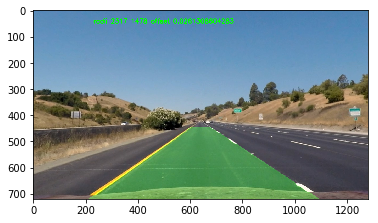

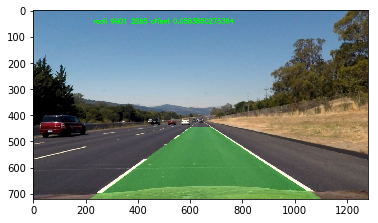

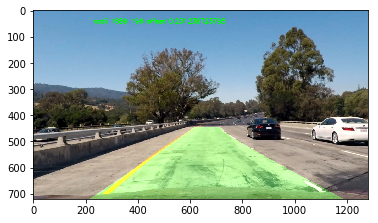

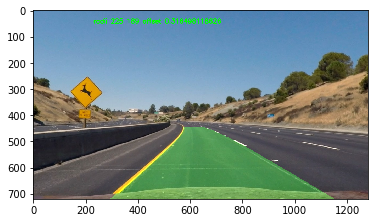

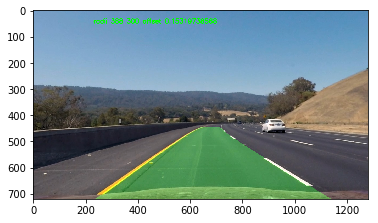

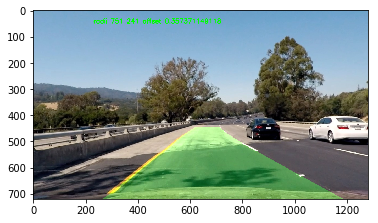

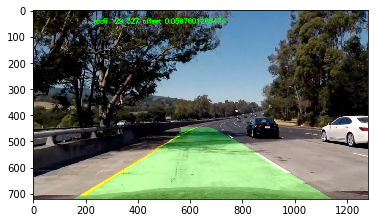

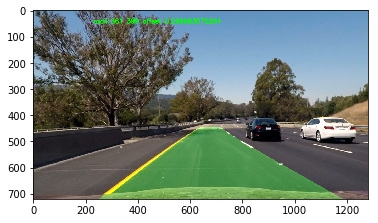

In [81]:
lanes = [find_lanes(x,M,Minv) for x in undistorted_imgs]
for x in lanes:
    plt.figure()
    plt.imshow(x)

In [56]:
genvideo('project_video.mp4','output_project_video.mp4',lambda x:find_lanes(x,M,Minv))
showvideo('output_project_video.mp4')


[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [03:44<00:00,  6.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 



<class 'numpy.ndarray'>
(512, 512, 3)


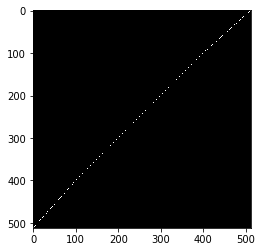

In [119]:
pts = [np.array([[x,y] for x,y in zip(range(0,500,100),range(1,501,100))]),np.array([[0,512],[100,400],[200,300],[300,200],[400,100],[512,0]])]
img = np.zeros((512,512,3),np.uint8)
#img = np.zeros((512,512,3), np.uint8)
ret = cv2.polylines(img,pts,False,(255,255,255))
cv2.imwrite("out.jpg",img)
print(type(ret))
print(ret.shape)
plt.imshow(img)


In [111]:
A = np.asarray(range(100))
A = A.reshape((10,10))
nz = A.nonzero()
nzx=np.array(nz[0])
nzy=np.array(nz[1])
print(nzx)
print(nzy)
((nzx>=5) & (nzx<8) & (nzy>=5) & (nzy<8)).nonzero()[0]
[[x,y] for x,y in zip(range(0,500,100),range(1,501,100))]

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7
 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
[1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7
 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4
 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


[[0, 1], [100, 101], [200, 201], [300, 301], [400, 401]]

In [59]:
x = 'abc' "def"
x

'abcdef'

In [62]:
a,b=np.asarray([1,2,3]),np.asarray([4,5,6])
np.vstack((a,b))

array([[1, 2, 3],
       [4, 5, 6]])

In [63]:
help(np.stack)

Help on function stack in module numpy.core.shape_base:

stack(arrays, axis=0)
    Join a sequence of arrays along a new axis.
    
    The `axis` parameter specifies the index of the new axis in the dimensions
    of the result. For example, if ``axis=0`` it will be the first dimension
    and if ``axis=-1`` it will be the last dimension.
    
    .. versionadded:: 1.10.0
    
    Parameters
    ----------
    arrays : sequence of array_like
        Each array must have the same shape.
    axis : int, optional
        The axis in the result array along which the input arrays are stacked.
    
    Returns
    -------
    stacked : ndarray
        The stacked array has one more dimension than the input arrays.
    
    See Also
    --------
    concatenate : Join a sequence of arrays along an existing axis.
    split : Split array into a list of multiple sub-arrays of equal size.
    block : Assemble arrays from blocks.
    
    Examples
    --------
    >>> arrays = [np.random.randn(3,